In [2]:
# 使用Prophet預測股票
# basic
import numpy as np
import pandas as pd

# get data
import yfinance as yf
import pandas_datareader.data as pdr

# visual
import matplotlib.pyplot as plt
%matplotlib inline
#time
import datetime as datetime

#Prophet
from fbprophet import Prophet

from sklearn import metrics

請輸入股票-->1314.TW
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-05  11.000000  11.666666  10.904761  11.571428  10.662335  105299250
2015-01-06  11.428571  11.952380  11.238095  11.857142  10.925603   98024850
2015-01-07  11.904761  12.190476  11.619047  11.619047  10.706213   83179950
2015-01-08  11.714285  12.000000  11.714285  11.761904  10.837847   61997250
2015-01-09  11.809523  11.904761  11.619047  11.666666  10.750092   45198300


Text(0.5, 1.0, '1314.TW')

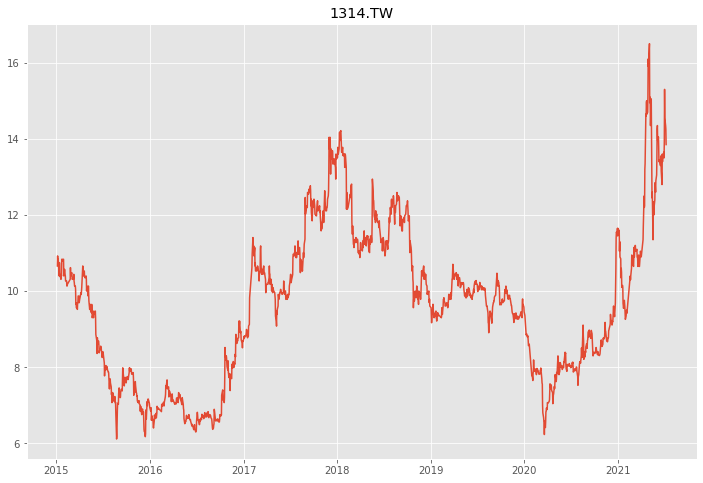

In [3]:
# 讀取股票
yf.pdr_override()
start = datetime.datetime(2015,1,1)
stock = str(input("請輸入股票-->"))
df_stock = pdr.get_data_yahoo(stock, start)
print(df_stock.head())
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))
plt.plot(df_stock['Adj Close'])
plt.title(stock)

In [5]:
new_df_stock = pd.DataFrame(df_stock['Adj Close']).reset_index().rename(columns={'Date':'ds','Adj Close':'y'})
print(new_df_stock.head())

          ds          y
0 2015-01-05  10.662335
1 2015-01-06  10.925603
2 2015-01-07  10.706213
3 2015-01-08  10.837847
4 2015-01-09  10.750092


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-01-05  2.399568    2.357541    2.484740     2.399568     2.399568   
1 2015-01-06  2.397904    2.346280    2.474767     2.397904     2.397904   
2 2015-01-07  2.396240    2.344973    2.471411     2.396240     2.396240   
3 2015-01-08  2.394575    2.337615    2.468653     2.394575     2.394575   
4 2015-01-09  2.392911    2.334619    2.471217     2.392911     2.392911   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        0.017666              0.017666              0.017666  0.011748   
1        0.015586              0.015586              0.015586  0.011769   
2        0.012369              0.012369              0.012369  0.010904   
3        0.010845              0.010845              0.010845  0.011944   
4        0.005977              0.005977              0.005977  0.009808   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      0.011748      

Text(0.5, 1.0, '1314.TW一年預測走勢')

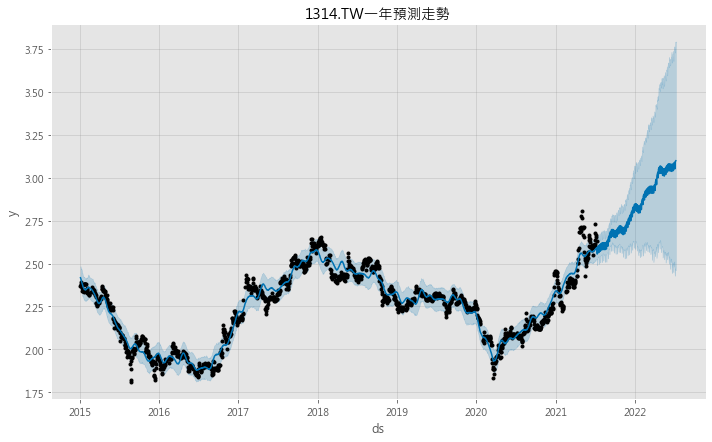

In [6]:
# 使用Prophet來預測股票
new_df_stock['y'] = np.log(new_df_stock['y'])
# 定義模型
model = Prophet()
# 訓練模型
model.fit(new_df_stock)
# 建立預測集
future = model.make_future_dataframe(periods=365)
# 進行預測
forecast = model.predict(future)
print(forecast.head())
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
model.plot(forecast,figsize=(10, 6))
plt.title(stock+"一年預測走勢")

            Adj Close      yhat  yhat_upper  yhat_lower
ds                                                     
2018-03-23  11.013358  2.472233    2.532088    2.403788
2018-03-26  11.013358  2.468044    2.533707    2.403980
2018-03-27  11.057237  2.466589    2.533566    2.408487
2018-03-28  10.969481  2.464595    2.524376    2.397705
2018-03-29  11.013358  2.464880    2.535274    2.402518
            Adj Close       yhat  yhat_upper  yhat_lower
ds                                                      
2018-03-23  11.013358  11.848874   12.579746   11.065010
2018-03-26  11.013358  11.799342   12.600134   11.067135
2018-03-27  11.057237  11.782194   12.598358   11.117129
2018-03-28  10.969481  11.758713   12.483106   10.997906
2018-03-29  11.013358  11.762067   12.619892   11.050970


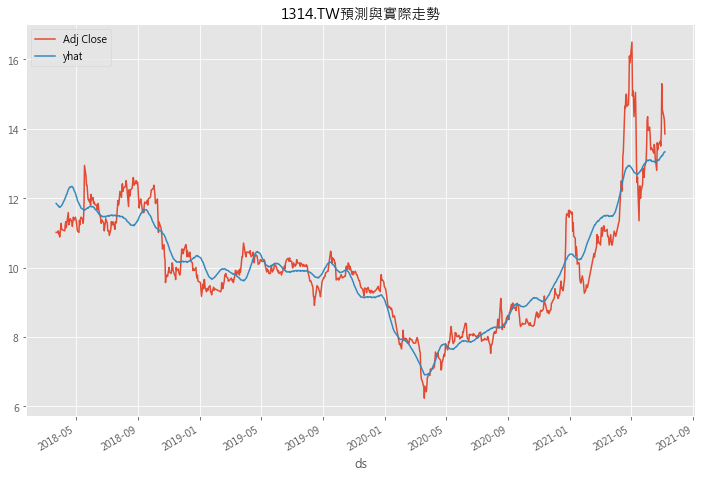

In [10]:
# 看預測和實際數據的最後800筆(一年252筆)
df_stock_close = pd.DataFrame(df_stock['Adj Close'])
two_years = forecast.set_index('ds').join(df_stock_close)
two_years = two_years[['Adj Close','yhat','yhat_upper','yhat_lower']].dropna().tail(800)
print(two_years.head())
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)
print(two_years.head())
two_years[['Adj Close', 'yhat']].plot(figsize=(12, 8))
plt.title(stock+"預測與實際走勢")
plt.show()

In [11]:
two_years_AE = (two_years.yhat-two_years['Adj Close'])
print(two_years_AE.describe())
# MSE：均方誤差( MSE越接近0越好 )
print('MSE:', metrics.mean_squared_error(two_years.yhat,two_years['Adj Close']))
# MAE：平均絕對誤差
print('MAE:', metrics.mean_absolute_error(two_years.yhat,two_years['Adj Close']))

count    800.000000
mean      -0.012631
std        0.587709
min       -3.642972
25%       -0.255946
50%        0.026583
75%        0.366877
max        1.385823
dtype: float64
MSE: 0.34513012502188134
MAE: 0.4257273395858666


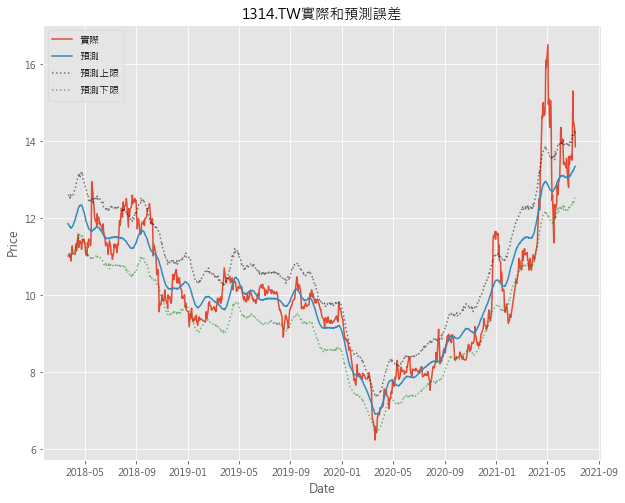

In [12]:
# 繪圖
fig,ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(two_years['Adj Close'],label='實際')
ax1.plot(two_years.yhat,label='預測')
ax1.plot(two_years.yhat_upper,label='預測上限',color = 'black', linestyle = ':',alpha=0.5)
ax1.plot(two_years.yhat_lower,label='預測下限',color = 'green', linestyle = ':',alpha=0.5)
ax1.set_title(stock+'實際和預測誤差')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
ax1.legend()
plt.show()

In [13]:
# 繪製K線圖
import talib
import mpl_finance as mpf
start = datetime.datetime(2021,1,1)
stock = str(input('請輸入繪製K線圖的股票:'))
df_stock = pdr.get_data_yahoo(stock, start)
df_stock.index = df_stock.index.format(formatter=lambda x : x.strftime('%Y-%m-%d'))
# 加上10日均線與30日均線
sma_10 = talib.SMA(np.array(df_stock['Close']),10)
sma_30 = talib.SMA(np.array(df_stock['Close']),30)

# KD指標(公式請查旁邊列表)
df_stock['k'],df_stock['d'] = talib.STOCH(df_stock['High'], df_stock['Low'],
                                        df_stock['Close'])
df_stock['k'].fillna(value=0, inplace= True)
df_stock['d'].fillna(value=0, inplace= True)

請輸入繪製K線圖的股票:1314.TW
[*********************100%***********************]  1 of 1 completed


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, '1314.TW的K線圖&KD值圖&交易量圖')

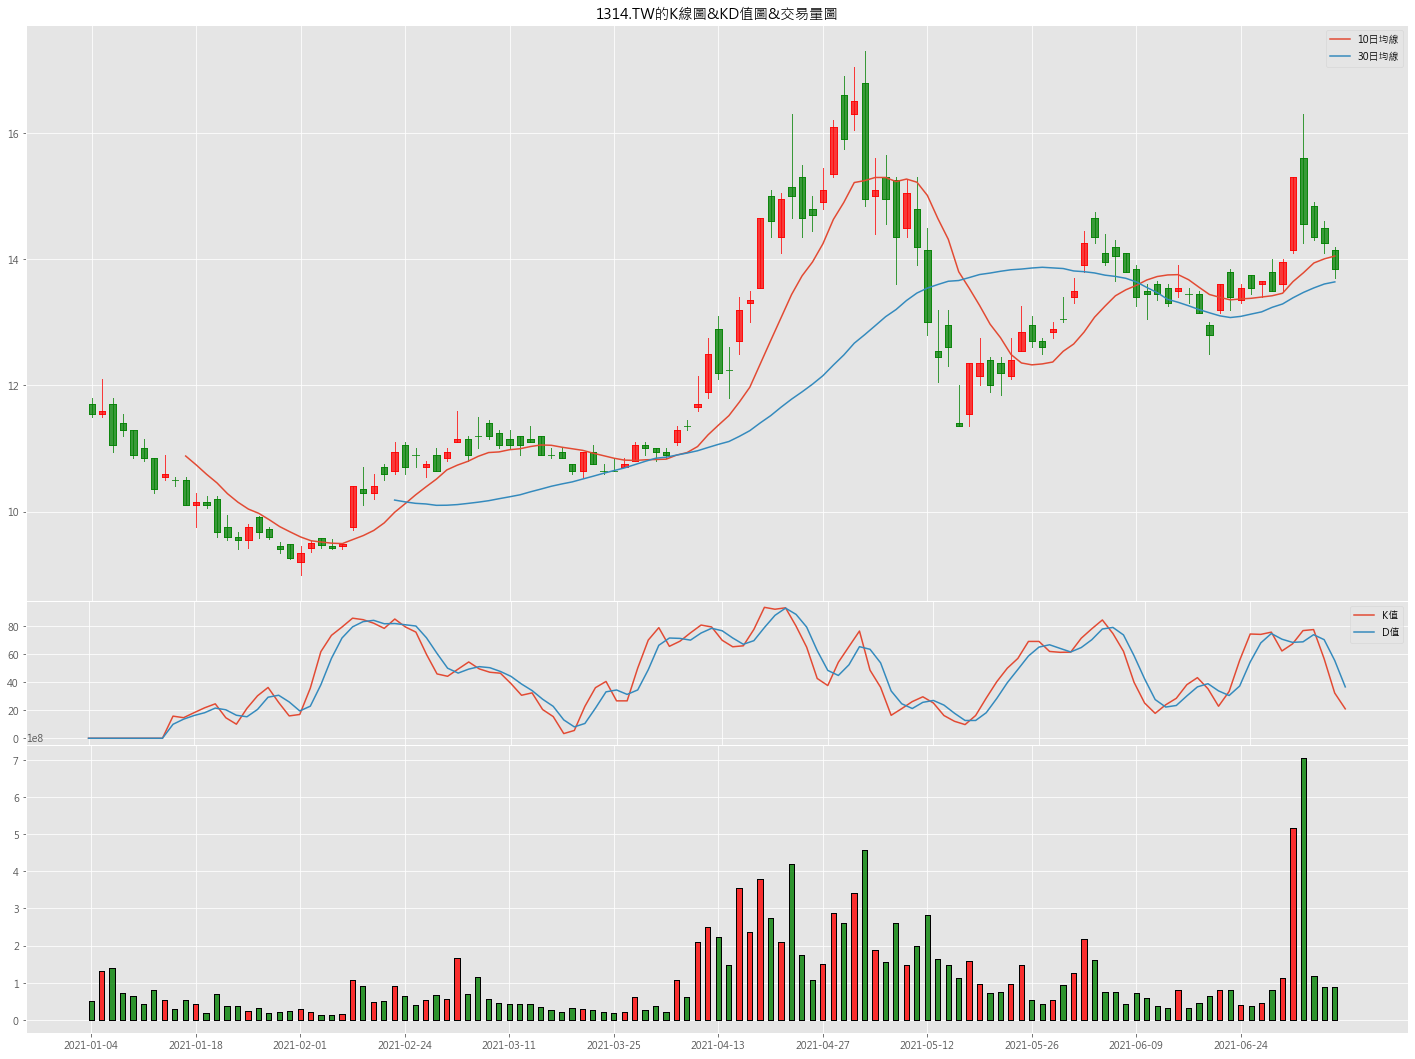

In [14]:
#繪圖
fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0.1,0.4,0.8,0.4])
ax2 = fig.add_axes([0.1,0.3,0.8,0.1])
ax3 = fig.add_axes([0.1,0.1,0.8,0.2])
ax.set_xticks(range(0,len(df_stock.index), 10))
ax.set_xticklabels(df_stock.index[::10])
mpf.candlestick2_ochl(ax, df_stock['Open'], df_stock['Close'], df_stock['High'],
                      df_stock['Low'], width=0.6, colorup='r',colordown='g',
                      alpha=0.75)
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(sma_10, label = '10日均線')
ax.plot(sma_30, label = '30日均線')

ax2.plot(df_stock['k'],label='K值')
ax2.plot(df_stock['d'],label='D值')
ax2.set_xticks(range(0,len(df_stock.index), 10))
ax2.set_xticklabels(df_stock.index[::10]) 

mpf.volume_overlay(ax3, df_stock['Open'], df_stock['Close'], df_stock['Volume'],
                   width=0.5, colorup='r', colordown='g', alpha=0.8)
ax3.set_xticks(range(0,len(df_stock.index), 10))
ax3.set_xticklabels(df_stock.index[::10])
ax.legend()
ax2.legend()
ax.set_title(stock+"的K線圖&KD值圖&交易量圖")

In [15]:
start = datetime.datetime(2015, 1 ,1)
stock = str(input('請輸入投資的股票:'))
df_stock = pdr.get_data_yahoo(stock, start)

# 收盤價和第一天的收盤價的比較

df_stock['normalized_price'] = df_stock['Adj Close']/df_stock['Adj Close'].iloc[0]
print(df_stock.head())

請輸入投資的股票:1314.TW
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2015-01-05  11.000000  11.666666  10.904761  11.571428  10.662335  105299250   
2015-01-06  11.428571  11.952380  11.238095  11.857142  10.925603   98024850   
2015-01-07  11.904761  12.190476  11.619047  11.619047  10.706213   83179950   
2015-01-08  11.714285  12.000000  11.714285  11.761904  10.837847   61997250   
2015-01-09  11.809523  11.904761  11.619047  11.666666  10.750092   45198300   

            normalized_price  
Date                          
2015-01-05          1.000000  
2015-01-06          1.024691  
2015-01-07          1.004115  
2015-01-08          1.016461  
2015-01-09          1.008230  


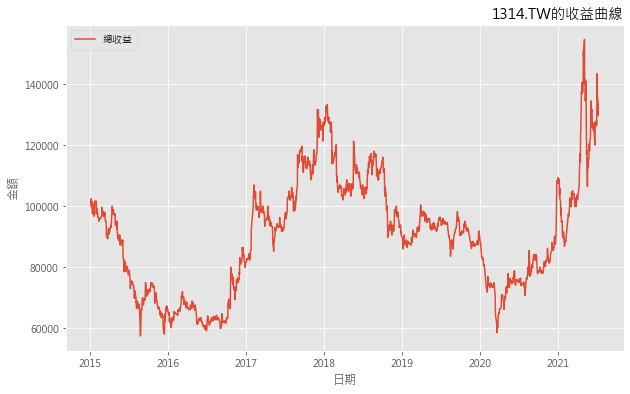

In [16]:
# 資產分配
# 我們將我們的投資金額用以下的比例分配
# 之後將分配到的比例乘上每一日的收益率
# stock 100%
weight=1
df_stock['weighted daily return']=df_stock['normalized_price']*weight
# 將股票的收益率乘上你要投資的總金額，現在假設是10萬
df_stock['Total Pos']= df_stock['weighted daily return']*100000
# 將剛剛總收益繪製圖表
fig = plt.figure(figsize=(10,6))
plt.plot(df_stock['Total Pos'], '-', label = '總收益')
plt.title(stock+'的收益曲線', loc='right')
plt.xlabel('日期')
plt.ylabel('金額')
plt.grid(True, axis = 'y')
plt.legend()

累積收益率: 0.2989649891250381
平均收益率 0.0003624855447217189
收益率標準差 0.01992562476426223


C:\Users\mshome\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\mshome\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mshome\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


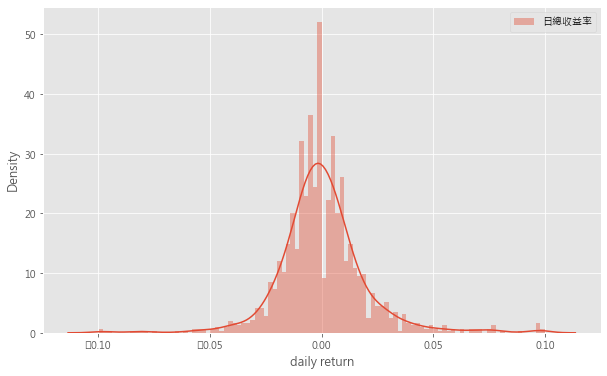

In [18]:
# 日收益率
df_stock['daily return']=df_stock['weighted daily return'].pct_change()
# 累積收益率
print("累積收益率:",df_stock['weighted daily return'].iloc[-1]/df_stock['weighted daily return'].iloc[0]-1)
# 平均日收益率
print("平均收益率",df_stock['daily return'].mean())
# 收益率標準差
print("收益率標準差",df_stock['daily return'].std())
# 使用密度圖來顯示日收益率
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.distplot(df_stock['daily return'].dropna(),bins=100, label='日總收益率')
plt.legend()

In [19]:
# 夏普指數(Sharpe ratio)
SR = df_stock['daily return'].mean()/df_stock['daily return'].std()
print(stock+'夏普指數',SR)
# 一年總共有252天的交易日
ASR = np.sqrt(252)*SR
print(stock+'風險%',ASR)


print('代表投資者每增加','%.2f'%(ASR),"%",'的風險可以換來','%.2f'%(SR*100),"%")

1314.TW夏普指數 0.01819192868531068
1314.TW風險% 0.2887879150197256
代表投資者每增加 0.29 % 的風險可以換來 1.82 %
